In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import ttest_rel
from vrAnalysis.helpers import errorPlot
from photometry.loaders import get_doric_files, process_data_parallel

from syd import make_viewer

In [23]:
mouse_name = "ATL066"
dirs, findex, data = get_doric_files(mouse_name)
print(f"Found {len(data)} files")

Found 1 files


In [24]:
# Get the results from all sessions of the data files
preperiod = 0.2
postperiod = 1.0
results, opto_responses = process_data_parallel(data, preperiod=preperiod, postperiod=postperiod)

Processing files: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


In [25]:
import numpy as np

def plot(state):
    idx_session = state["idx_session"]
    
    res = results[idx_session]

    cmap = plt.get_cmap("cividis")
    colors = np.array([cmap(i/len(results)) for i in range(len(results))])

    fig = plt.figure(figsize=(12, 4), layout="constrained")
    gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 0.2, 1.0], wspace=0.1)

    # Plot all sessions
    ax = fig.add_subplot(gs[0])
    for iresponse, response in enumerate(opto_responses):
        ax.plot(res["time_opto_response"], response, color=colors[iresponse] if iresponse != idx_session else "k", zorder=1 if iresponse != idx_session else 1000)
    ax.set_xlim(-preperiod, postperiod/2)
    ax.axhline(0, color="black", linewidth=0.5, linestyle="--", zorder=-100)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel(r"$\Delta$ Fluorescence (a.u.)")
    ax.set_title("Session Averages")

    # Plot the current session's data in particular
    ax = fig.add_subplot(gs[1])
    errorPlot(res["time_opto"], res["in1_opto"], se=True, axis=0, ax=ax, alpha=0.2, color="black", label="iso")
    errorPlot(res["time_opto"], res["in2_opto"], se=True, axis=0, ax=ax, alpha=0.2, color="green", label="fluor")
    ax.axvline(0, color="black", linewidth=0.5, linestyle="--", zorder=-100)
    ax.legend(loc="upper right")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel(r"$\Delta$ Fluorescence (a.u.)")
    ax.set_title("Session Average")
    ax.set_xlim(-preperiod, 0.8)

    ax_cbar = fig.add_subplot(gs[2])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, len(results)-1))
    cbar = plt.colorbar(sm, cax=ax_cbar, label='Session #')
    cbar.set_ticks([0, len(results)-1])  # Only show first and last session numbers
    cbar.set_ticklabels(['1', str(len(results))])  # Label them as 1 and max

    # Plot all the data from the selected session
    ax = fig.add_subplot(gs[3])
    relative_data = res["in2_opto"] - res["in1_opto"]
    relative_data = relative_data - np.median(relative_data)
    relative_data = relative_data / np.std(relative_data)
    ax.imshow(relative_data, aspect="auto", cmap="bwr", extent=[-preperiod, postperiod, 0, len(relative_data)], vmin=-state["vmax"], vmax=state["vmax"])
    ax.axvline(0, color="black", linewidth=0.5, linestyle="--")
    ax.set_xlim(-preperiod, postperiod)
    ax.set_ylim(0, len(relative_data))
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Trial #")
    ax.set_title("Session Trials")
    
    fig.suptitle(f"{mouse_name}")
    return fig


viewer = make_viewer(plot)
viewer.add_integer("idx_session", value=12, min=0, max=len(results)-1)
viewer.add_float("vmax", value=4.0, min=0.1, max=10)
viewer.deploy(env="notebook");

C:\Users\Andrew\Documents\GitHub\syd\syd\parameters.py:768: ParameterUpdateWarning: Warning updating IntegerParameter parameter 'idx_session': Value 12 above maximum 0, clamping
  warn(


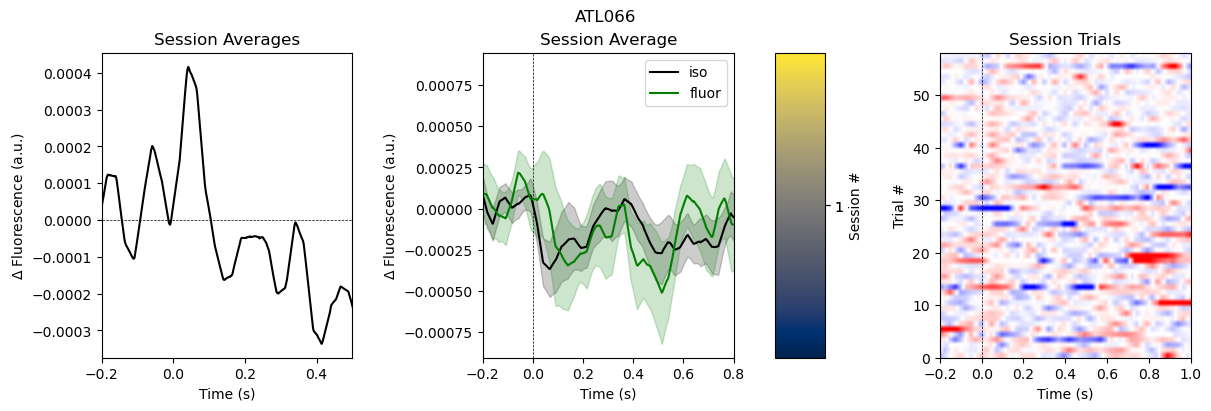

In [26]:
from vrAnalysis2.helpers import save_figure
from vrAnalysis2.files import repo_path
figure_path = repo_path() / "figures" / "photometry" / f"{mouse_name}.png"
fig = viewer.plot(viewer.state)
save_figure(fig, figure_path)